# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [16]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Read files

In [3]:
# Load files into a pandas dataframe
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
ss = pd.read_csv('../data/SampleSubmission.csv')

## Eploratory Data Analysis

In [ ]:
# Preview the first five rows of the train set
train.head()

In [ ]:
# Preview the first five rows of the test set
test.head(20)
# test["Car_Category"].value_counts()

In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

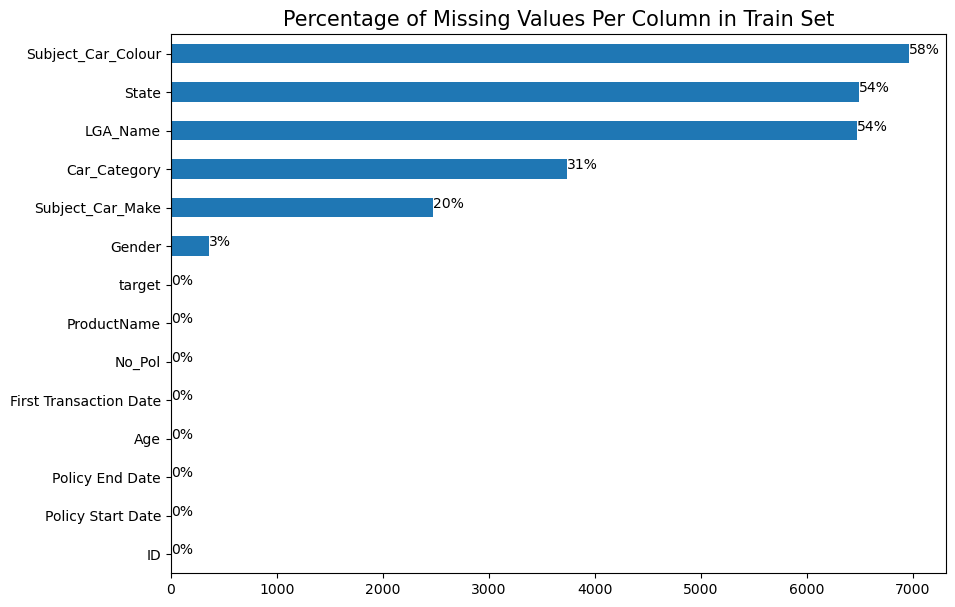

In [4]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
train["Gender"].value_counts()

### Imputing Gender with Mode

In [3]:
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])

### Imputing Age

In [4]:
def clean_age(age):
    if pd.isna(age) or age < 0 or age > 100:
        return np.nan
    return age

train['Age'] = train['Age'].apply(clean_age)
test['Age'] = test['Age'].apply(clean_age)


age_average = train['Age'].mean()
age_average_test = test['Age'].mean()

train['Age'].fillna(age_average, inplace=True)
test['Age'].fillna(age_average_test, inplace=True)

### Replacing Dots

In [5]:
train['Subject_Car_Make'] = train['Subject_Car_Make'].replace('.', np.nan)

### Backfill Method

In [6]:
def backfill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='bfill')
    return data

                   
backfill_columns = ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']
    
backfilled_data = backfill_data(train, backfill_columns)

print("Original Data:")
print(train)
print("\nBackfilled Data:")
print(backfilled_data)


Original Data:
               ID Policy Start Date Policy End Date  Gender        Age  \
0      ID_0040R73        2010-05-14      2011-05-13    Male  30.000000   
1      ID_0046BNK        2010-11-29      2011-11-28  Female  79.000000   
2      ID_005QMC3        2010-03-21      2011-03-20    Male  43.000000   
3      ID_0079OHW        2010-08-21      2011-08-20    Male   2.000000   
4      ID_00BRP63        2010-08-29      2010-12-31  Entity  20.000000   
...           ...               ...             ...     ...        ...   
12074  ID_ZZA1SES        2010-05-25      2011-05-24  Female  30.000000   
12075  ID_ZZDAC3K        2010-10-03      2011-10-02  Female  59.000000   
12076  ID_ZZIU2XC        2010-10-10      2011-10-08    Male  34.000000   
12077  ID_ZZRQ1NF        2010-02-27      2011-02-26    Male  41.153991   
12078  ID_ZZWRIIE        2010-07-01      2011-06-30  Female  46.000000   

      First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0                 2010-0

In [7]:
def backfill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='bfill')
    return data

                   
backfill_columns = ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']
    
backfilled_data = backfill_data(test, backfill_columns)

print("Original Data:")
print(test)
print("\nBackfilled Data:")
print(backfilled_data)

Original Data:
              ID Policy Start Date Policy End Date  Gender        Age  \
0     ID_01QM0NU        2010-10-23      2011-10-22  Female  46.000000   
1     ID_024NJLZ        2010-10-14      2011-10-13    Male  32.000000   
2     ID_02NOVWQ        2010-08-29      2011-08-28  Female  45.000000   
3     ID_02VSP68        2010-06-13      2011-06-12  Female  58.000000   
4     ID_02YB37K        2010-07-01      2011-06-30    Male  41.319241   
...          ...               ...             ...     ...        ...   
1197  ID_ZTTHC5X        2010-12-05      2011-12-04    Male  67.000000   
1198  ID_ZUJAFUP        2010-01-14      2011-01-13    Male  43.000000   
1199  ID_ZWHCTUM        2010-07-26      2011-07-25    Male  30.000000   
1200  ID_ZWQRL8L        2010-02-16      2011-02-15    Male  44.000000   
1201  ID_ZWZ92GU        2010-03-18      2011-03-17    Male  28.000000   

     First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0                2010-10-23       1  

### Change Dates

In [6]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['Policy End Date'] = pd.to_datetime(train['Policy End Date'])
train['First Transaction Date'] = pd.to_datetime(train['First Transaction Date'])

test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['Policy End Date'] = pd.to_datetime(test['Policy End Date'])
test['First Transaction Date'] = pd.to_datetime(test['First Transaction Date'])

In [7]:
train['Policy_Duration'] = (train['Policy End Date'] - train['Policy Start Date']).dt.days
train['Customer_Tenure'] = (train['Policy Start Date'] - train['First Transaction Date']).dt.days
test['Policy_Duration'] = (test['Policy End Date'] - test['Policy Start Date']).dt.days
test['Customer_Tenure'] = (test['Policy Start Date'] - test['First Transaction Date']).dt.days

today = pd.Timestamp.today()
train['Recency'] = (today - train['Policy End Date']).dt.days
test['Recency'] = (today - test['Policy End Date']).dt.days

### Putting the target column at the end

In [15]:
target = "target"
train = train[[col for col in train.columns if col != target] + [target]]

## Encoding

In [9]:
categorical_columns = ['Gender', 'Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = encoder.fit_transform(train[categorical_columns])
encoded_test = encoder.transform(test[categorical_columns])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

train = train.drop(columns=categorical_columns).reset_index(drop=True)
test = test.drop(columns=categorical_columns).reset_index(drop=True)

train = pd.concat([train, encoded_train_df], axis=1)
test = pd.concat([test, encoded_test_df], axis=1)

### Model Building

In [11]:
X = train.drop(columns=['ID', 'target', 'Policy Start Date', 'Policy End Date', 'First Transaction Date'])
y = train['target']
X_test = test.drop(columns=['ID', 'Policy Start Date', 'Policy End Date', 'First Transaction Date'])

In [13]:
scaler = StandardScaler()
numerical_columns = ['Age', 'No_Pol', 'Policy_Duration', 'Customer_Tenure', 'Recency']
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [15]:
model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

In [17]:
train_predictions = model.predict(X)

f1 = f1_score(y, train_predictions)
precision = precision_score(y, train_predictions)
recall = recall_score(y, train_predictions)
conf_matrix = confusion_matrix(y, train_predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score: 0.7368
Precision: 0.9374
Recall: 0.6069
Confusion Matrix:
[[10565    59]
 [  572   883]]


In [18]:
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

feature_importances

,importance
Recency,0.180446
Age,0.133827
ProductName_CarSafe,0.078500
Policy_Duration,0.056664
No_Pol,0.028742
...,...
LGA_Name_Ebute-Metta,0.000000
LGA_Name_ENUGU SOUTH,0.000000
LGA_Name_EMENE,0.000000
LGA_Name_EFFURUN,0.000000


In [19]:
test_predictions = model.predict(X_test)

In [20]:
test_predictions = model.predict(X_test)
pd.DataFrame(test_predictions).value_counts()

0
0    1125
1      77
Name: count, dtype: int64

In [21]:
test_probabilities = model.predict_proba(X_test)

In [22]:
ss['target'] = test_predictions
ss.to_csv('submission.csv', index=False)